# 🧠 AI Data Breach Detection – Advanced EDA & SHAP

In [1]:
# 📦 Imports
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import joblib
import shap
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE

sns.set(style='whitegrid')
%matplotlib inline

In [2]:
# 📂 Load Preprocessed Data
columns = [
    'srcip', 'sport', 'dstip', 'dsport', 'proto', 'state', 'dur', 'sbytes', 'dbytes',
    'sttl', 'dttl', 'sloss', 'dloss', 'service', 'Sload', 'Dload', 'Spkts', 'Dpkts',
    'swin', 'dwin', 'stcpb', 'dtcpb', 'smeansz', 'dmeansz', 'trans_depth', 'res_bdy_len',
    'Sjit', 'Djit', 'Stime', 'Ltime', 'Sintpkt', 'Dintpkt', 'tcprtt', 'synack',
    'ackdat', 'is_sm_ips_ports', 'ct_state_ttl', 'ct_flw_http_mthd', 'is_ftp_login',
    'ct_ftp_cmd', 'ct_srv_src', 'ct_srv_dst', 'ct_dst_ltm', 'ct_src_ltm',
    'ct_src_dport_ltm', 'ct_dst_sport_ltm', 'ct_dst_src_ltm', 'attack_cat', 'label'
]

df1 = pd.read_csv('../Data/UNSW-NB15_1.csv', names=columns, skiprows=1, low_memory=False)
df2 = pd.read_csv('../Data/UNSW-NB15_2.csv', names=columns, skiprows=1, low_memory=False)
df = pd.concat([df1, df2], ignore_index=True)
df.drop(columns=['srcip', 'sport', 'dstip', 'dsport', 'attack_cat'], inplace=True)

In [3]:
# 🔧 Preprocessing
from sklearn.preprocessing import LabelEncoder
cat_columns = ['proto', 'service', 'state']
label_encoders = {}
for col in cat_columns:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    label_encoders[col] = le

df['ct_ftp_cmd'] = pd.to_numeric(df['ct_ftp_cmd'].replace(' ', np.nan), errors='coerce')
df = df.fillna(df.median(numeric_only=True))

In [4]:
# 🧪 Split + SMOTE
X = df.drop(columns=['label'])
y = df['label']

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train_resampled, y_train_resampled)

RandomForestClassifier(random_state=42)

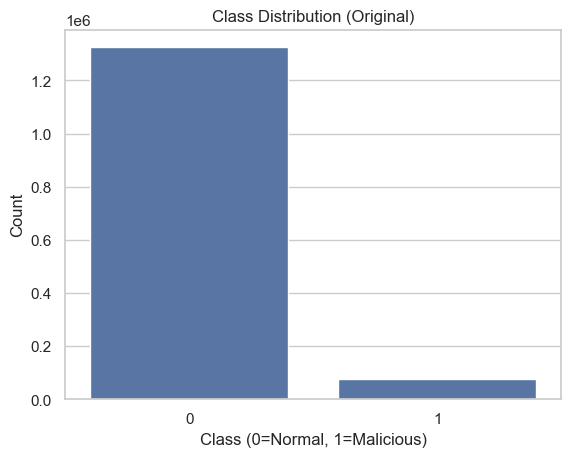

In [5]:
# 📊 Class Distribution
sns.countplot(x='label', data=df)
plt.title("Class Distribution (Original)")
plt.xlabel("Class (0=Normal, 1=Malicious)")
plt.ylabel("Count")
plt.show()

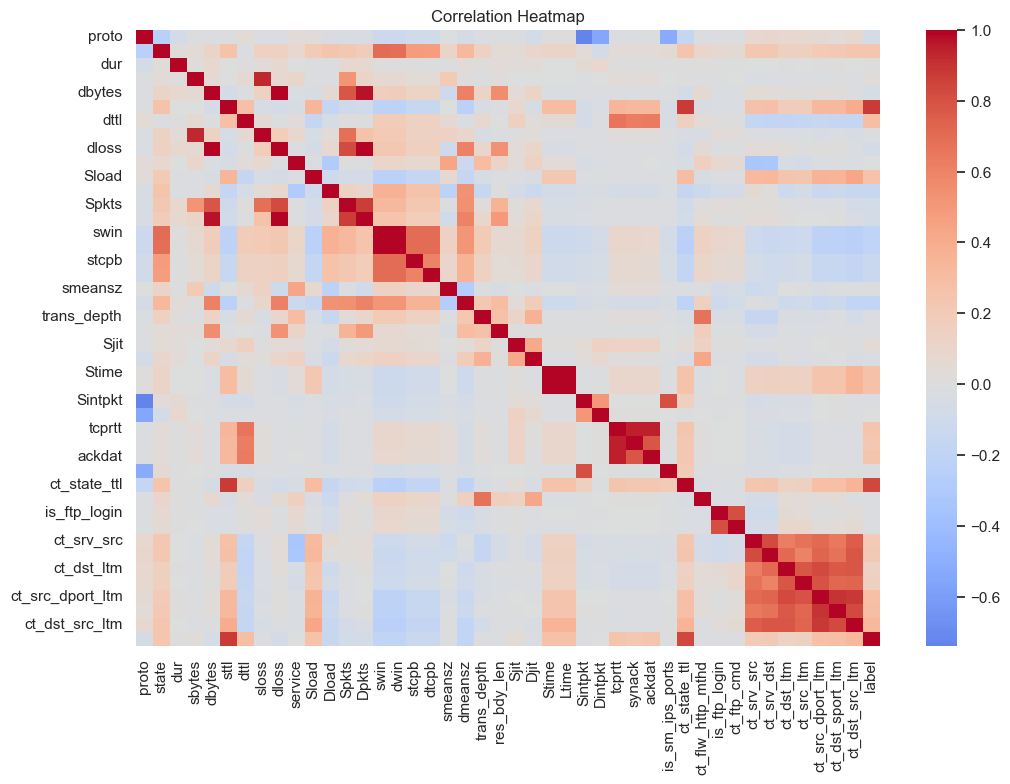

In [6]:
# 🔥 Feature Correlation
plt.figure(figsize=(12, 8))
corr = df.corr(numeric_only=True)
sns.heatmap(corr, cmap='coolwarm', center=0)
plt.title("Correlation Heatmap")
plt.show()

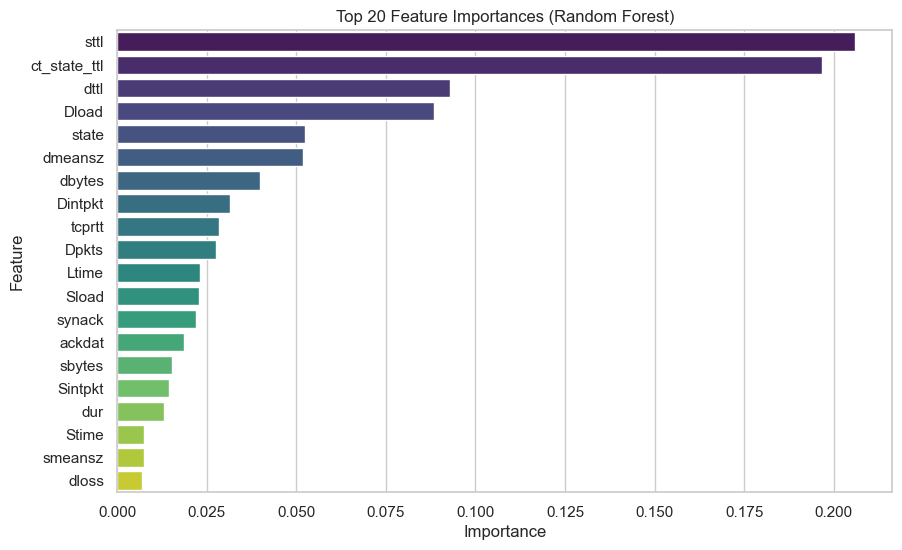

In [10]:
# 🌟 Feature Importance (Random Forest)
importances = rf.feature_importances_
feat_names = X.columns
feat_df = pd.DataFrame({'Feature': feat_names, 'Importance': importances}).sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feat_df.head(20), palette='viridis', hue='Feature',legend=False)
plt.title("Top 20 Feature Importances (Random Forest)")
plt.show()

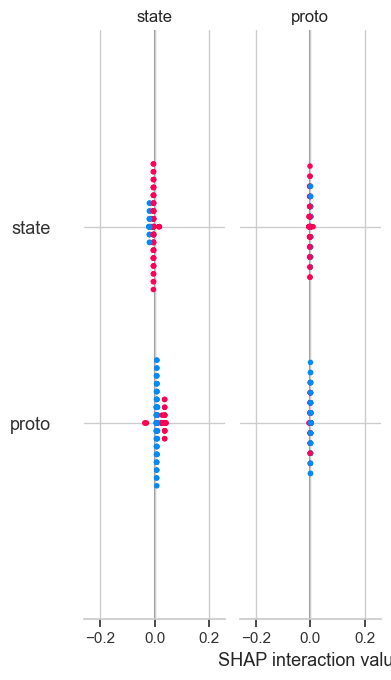

In [8]:
# 🧠 SHAP Values (Global Explainability)
explainer = shap.Explainer(rf, X_train_resampled)
shap_values = explainer(X_test[:100])

shap.summary_plot(shap_values, X_test[:100])